# Описание проекта
Подготовить прототип модели машинного обучения для компании, которая разрабатывает решения для эффективной работы промышленных предприятий.  

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. В нашем распоряжении данные с параметрами добычи и очистки.  

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

### Стадии получения золота из руды: 

#### 1. Флотация  

Во флотационную установку подаётся смесь золотосодержащей руды. После обогащения получается черновой концентрат и «отвальные хвосты», то есть остатки продукта с низкой концентрацией ценных металлов.
На стабильность этого процесса влияет непостоянное и неоптимальное физико-химическое состояние флотационной пульпы (смеси твёрдых частиц и жидкости).  

#### 2. Очистка  

Черновой концентрат проходит две очистки. На выходе получается финальный концентрат и новые отвальные хвосты.

## Описание данных

Данные находятся в трёх файлах:  

- **`gold_industry_train.csv`** — обучающая выборка;

- **`gold_industry_test.csv`** — тестовая выборка;

- **`gold_industry_full.csv`** — исходные данные.  

Данные индексируются датой и временем получения информации (признак `date`). Соседние по времени параметры часто похожи.  

Некоторые параметры недоступны, потому что замеряются и/или рассчитываются значительно позже. Из-за этого в тестовой выборке отсутствуют некоторые признаки, которые могут быть в обучающей. Также в тестовом наборе нет целевых признаков.  

Исходный датасет содержит обучающую и тестовую выборки со всеми признаками.

### Технологический процесс:  

- **`Rougher feed`** — исходное сырье

- **`Rougher additions`** (или **`reagent additions`**) — флотационные реагенты: `Xanthate`, `Sulphate`, `Depressant`

    - `Xanthate` — ксантогенат (промотер, или активатор флотации);

    - `Sulphate` — сульфат (на данном производстве сульфид натрия);
    
    - `Depressant` — депрессант (силикат натрия).

- **`Rougher process`** (англ. «грубый процесс») — флотация

- **`Rougher tails`** — отвальные хвосты

- **`Float banks`** — флотационная установка

- **`Cleaner process`** — очистка

- **`Rougher Au`** — черновой концентрат золота

- **`Final Au`** — финальный концентрат золота  

### Параметры этапов:

- `air amount` — объём воздуха

- `fluid levels` — уровень жидкости

- `feed size` — размер гранул сырья

- `feed rate` — скорость подачи  

### Наименование признаков  

Наименование признаков должно быть такое:  

- **`[этап].[тип_параметра].[название_параметра]`**  

Пример: `rougher.input.feed_ag`  

#### Возможные значения для блока [этап]:

- `rougher` — флотация

- `primary_cleaner` — первичная очистка

- `secondary_cleaner` — вторичная очистка

- `final` — финальные характеристики  

#### Возможные значения для блока [тип_параметра]:  

- `input` — параметры сырья

- `output` — параметры продукта

- `state` — параметры, характеризующие текущее состояние этапа

- `calculation` — расчётные характеристики  


### Нужно спрогнозировать сразу две величины:

- эффективность обогащения чернового концентрата `rougher.output.recovery`;  

- эффективность обогащения финального концентрата `final.output.recovery`.

---

### Содержание:  
<font size=4><ol>
<li>Получение и первичный анализ данных
    <ul>
        <li>1.1. Получение и осмотр данных</li>
        <li>1.2. Корректность расчета эффективности</li>
        <li>1.3. Анализ признаков</li>
        <li>1.4. Предобработка данных</li>
    </ul>
</li>
<li>Разведочный анализ данных
    <ul>
        <li>2.1. Концентрация металлов</li>
        <li>2.2. Исходное сырьё</li>
    </ul>
</li>
<li>Построение модели
    <ul>
        <li>3.1. Расчет sMAPE</li>
        <li>3.2. Обучение и оценка моделей</li>
        <li>3.3. Проверка модели на тестовой выборке</li>
    </ul>
</li>
<li>Выводы</li>
</ol></font>

---
## Выполнение проекта

### 1. Получение и первичный анализ данных

Импортируем необходимые библиотеки и модули для работы.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error

#### 1.1. Получение и осмотр данных

Получим данные, и ознакомимся с ними. проверим типы данных в столбцах, наличие пропусков и дубликатов.

In [2]:
def get_data(path):
    df = pd.read_csv(path)
    df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d %H:%M:%S')
    display(df)
    print()
    df.info()
    print()
    tmp = df.dtypes
    tmp = tmp.reset_index()
    tmp.columns = ['field_name', 'field_type']
    tmp = tmp.groupby('field_type', as_index=False)\
             .agg(count_fields=('field_name', 'nunique'))
    display(tmp)
    print()
    print('Дубликатов в данных =', df.duplicated().sum())
    return df

In [3]:
df_train = get_data('/datasets/gold_industry_train.csv')

In [4]:
df_test = get_data('/datasets/gold_industry_test.csv')

In [5]:
df_full = get_data('/datasets/gold_industry_full.csv')

Дубликатов нет, типы данных корректны. Однако есть пропуски. В тестовой выборке отсутствует множество столбцов/признаков, которые есть в подном датафрейме и в обучающей выборке.  

Проверим соответствие размерности, чтобы убедиться что тестовая и обучающая выборки взяты из одного (полного датасета), а так же корректность размерности по отношению друг к другу.

In [6]:
df_train.shape[0] + df_test.shape[0] == df_full.shape[0]

In [7]:
print('Доля тернировочной выборки {:.1%}, доля тестовой выборки {:.1%}'.format(
      df_train.shape[0] / df_full.shape[0], df_test.shape[0] / df_full.shape[0]))

С этим ОК.

#### 1.2. Корректность расчета эффективности

Напишем функцию для проверки корректности расчета показателя `recovery` по формуле которую нам дали.

In [8]:
def recovery(df):
    c = df['rougher.output.concentrate_au']
    f = df['rougher.input.feed_au']
    t = df['rougher.output.tail_au']
    coeff = ((c * (f - t)) / (f * (c - t))) * 100
    return coeff

Сравним насколько показатели полученные нашим расчетом отличаются от тех, которые есть в таблице.

In [9]:
print('MAE = {:.20f}'.format(mean_absolute_error(y_true=df_train['rougher.output.recovery'], y_pred=recovery(df_train))))

Ошибка совсем не велика.

#### 1.3. Анализ признаков

Проверим какие признаки есть в обучающей выборке, которых нет в тестовой.

In [10]:
for i in sorted(df_train.drop(columns=df_test.columns).columns):
    print(i)

Судя по полному списку это "выходные" данные об очистке сырья, первичной и вторичной очистке концентрата, а так же данные об итоговых результатах процесса.

#### 1.4. Предобработка данных

Необходимо заполнить пропуски в данных. Поскольку по условию данные близкие по времени похожи, заполним пропуски методом `fillna('ffil')`

In [11]:
for df in [df_train, df_full, df_test]:
    df.fillna(method='ffill', inplace=True)

ОК.

### 2. Разведочный анализ данных

#### 2.1. Концентрация металлов

Проверим концентрацию металлов в сырье и её изменение на стадиях процесса. Для удобства визуализации составим словарь с признаками. А так же списки металлов и соответствующих им цветов.

In [12]:
metall_concentrate = {

                    'Металлов в сырье': ['rougher.input.feed_au', 
                                         'rougher.input.feed_ag', 
                                         'rougher.input.feed_pb'],

     'Металлов в черновом концентрате': ['rougher.output.concentrate_au', 
                                         'rougher.output.concentrate_ag', 
                                         'rougher.output.concentrate_pb'], 

       'Металлов после первой очистки': ['primary_cleaner.output.concentrate_au', 
                                         'primary_cleaner.output.concentrate_ag', 
                                         'primary_cleaner.output.concentrate_pb'], 

    'Металлов в финальном концентрате': ['final.output.concentrate_au', 
                                         'final.output.concentrate_ag', 
                                         'final.output.concentrate_pb']
                  
                  }

metalls = ['Au', 'Ag', 'Pb']

colors = ['gold', 'silver', 'grey']

Для единства измерений зафиксируем единые значения осей.  

Построим гистограммы.

In [13]:
plt.style.available

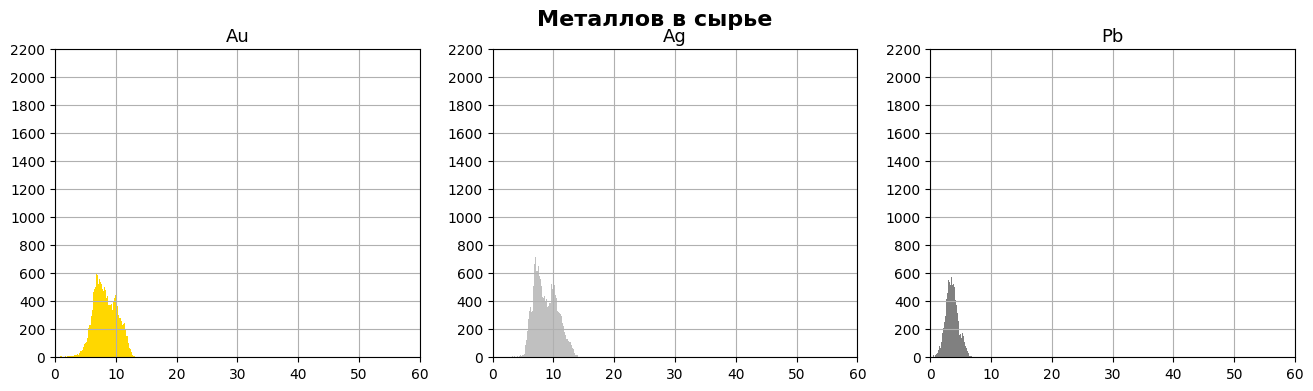

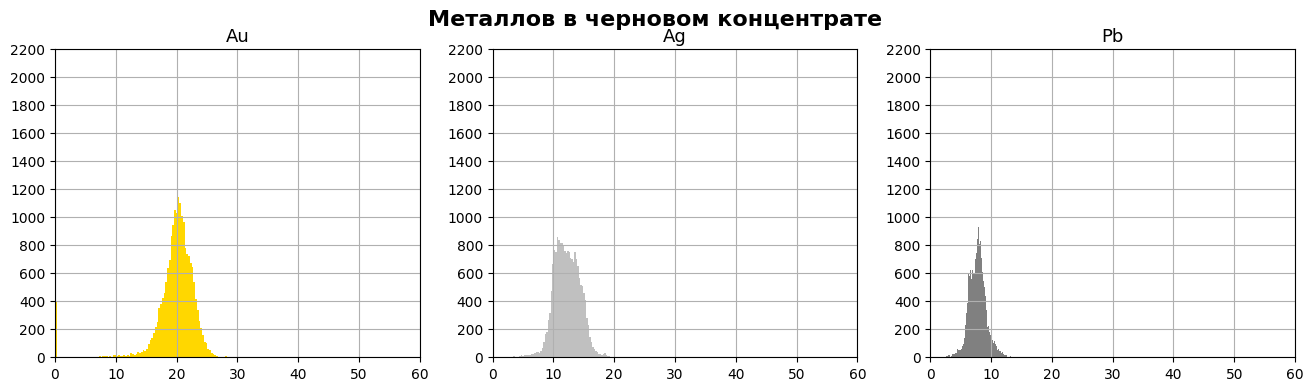

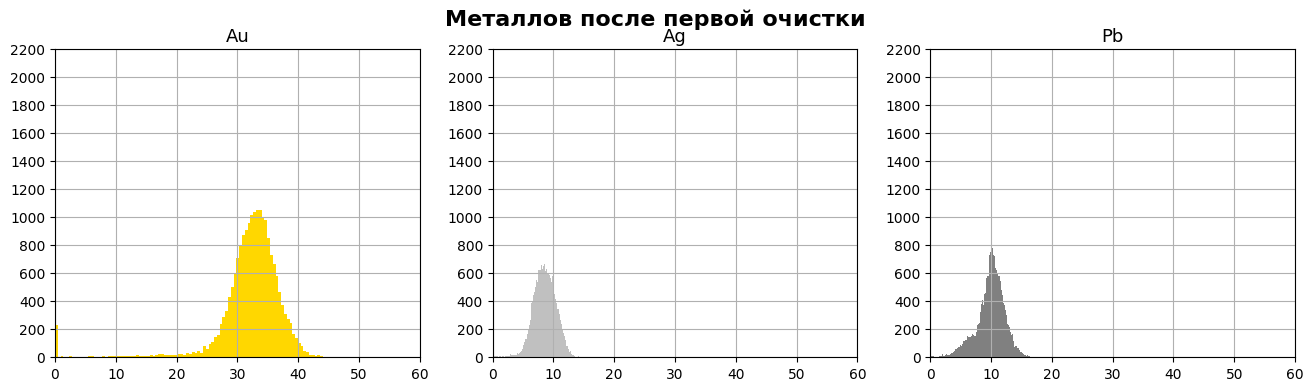

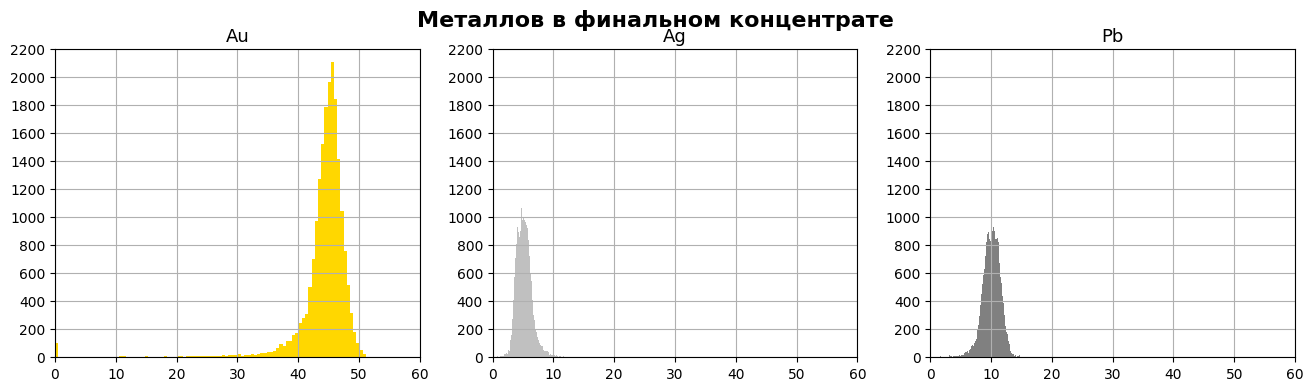

In [14]:
xticks = [i for i in range(0, 61, 10)]
yticks = [i for i in range(0, 2201, 200)]

with plt.style.context(style= 'seaborn-dark-palette'):   # 'seaborn-v0_8-dark'
    
    for param in metall_concentrate:

        fig, axes = plt.subplots(1, 3, sharex=True, figsize=(16, 4))
        fig.suptitle(param, fontsize=16, fontweight='bold')
        
        for num in range(3):

            axes[num].set_title(metalls[num], fontsize=13)
            axes[num].hist(df_full[metall_concentrate[param][num]], bins=100, color=colors[num])
            axes[num].grid(True)
            axes[num].set_xticks(xticks)
            axes[num].set_xlim(0, 60)
            axes[num].set_yticks(yticks)
            axes[num].set_ylim(0, 2200)

        plt.show()

Видно что концентрация золота вырастает существеннее всего. Однако концентрация серебра после обработки сырья растет, а затем снижается. Возможно то что хорошо подходит для золота, не так же хорошо подходит для серебра. Концентрация свинца тоже существенно вырастает только после флотации.  

Взглянем на суммарную концентрацию металлов в руде на различных этапах очистки.

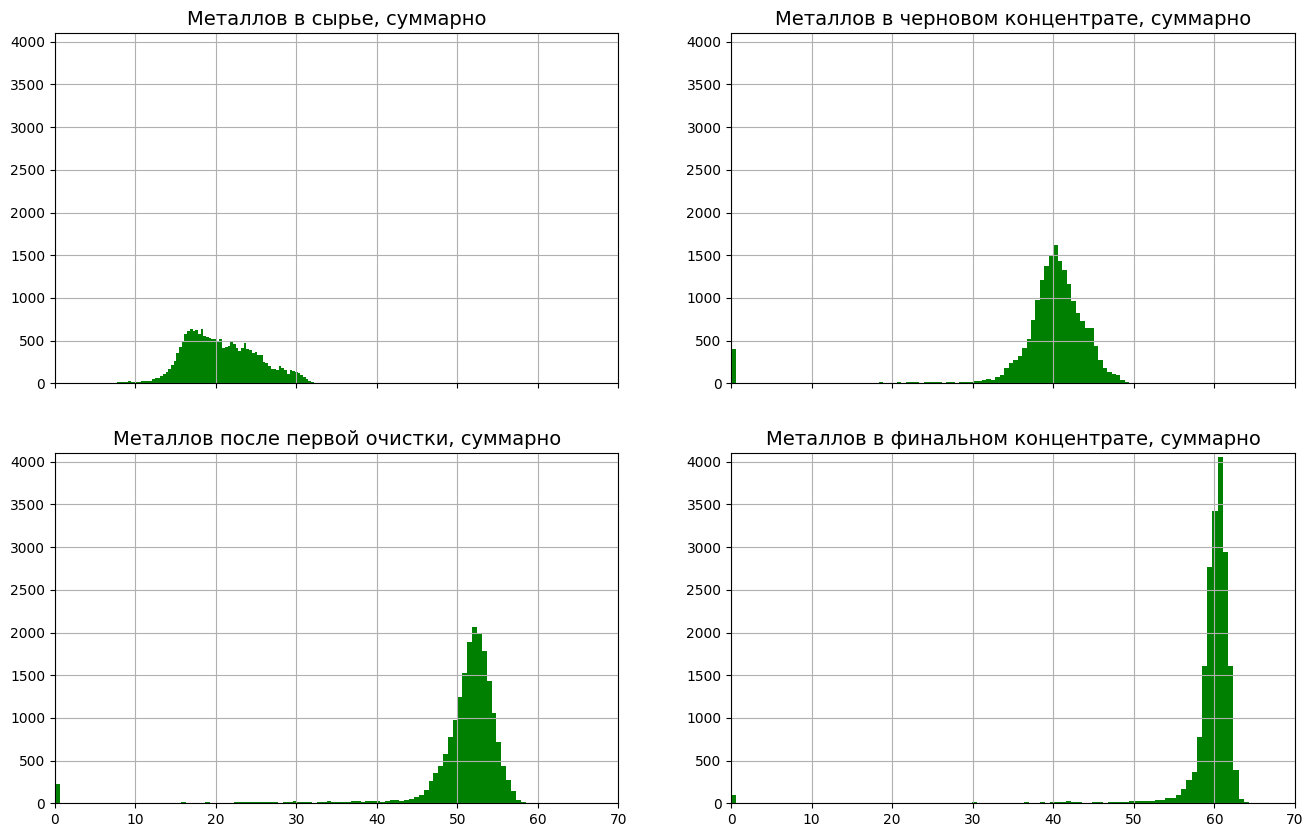

In [15]:
xticks = [i for i in range(0, 71, 10)]
yticks = [i for i in range(0, 4101, 500)]

r = 0
c = 0

with plt.style.context(style='seaborn-dark-palette'):   
    
    fig, axes = plt.subplots(2, 2, sharex=True, figsize=(16, 10))
    
    for param in metall_concentrate:

        axes[r, c].set_title(f'{param}, суммарно', fontsize=14)
        axes[r, c].hist(df_full[metall_concentrate[param][0]] + 
                        df_full[metall_concentrate[param][1]] + 
                        df_full[metall_concentrate[param][2]], 
                        bins=100, color='green')
        axes[r, c].grid(True)
        axes[r, c].set_xticks(xticks)
        axes[r, c].set_xlim(0, 70)
        axes[r, c].set_yticks(yticks)
        axes[r, c].set_ylim(0, 4100)

        if c > 0:
            c -= 1
            r += 1
        else:
            c += 1

plt.show()

Распределение нормальное, однако нулевые значения по сумме всех металлов ошибочны. Удалим такие данные из обучающей выборки, для корректного обучения модели.

In [16]:
df_train['raw_metalls_sum'] = df_train['rougher.input.feed_au'] + \
                              df_train['rougher.input.feed_ag'] + \
                              df_train['rougher.input.feed_pb']

df_train['flotation_metalls_sum'] = df_train['rougher.output.concentrate_au'] + \
                                    df_train['rougher.output.concentrate_ag'] + \
                                    df_train['rougher.output.concentrate_pb']

df_train['first_stage_metalls_sum'] = df_train['primary_cleaner.output.concentrate_au'] + \
                                      df_train['primary_cleaner.output.concentrate_ag'] + \
                                      df_train['primary_cleaner.output.concentrate_pb']

df_train['final_metall_sum'] = df_train['final.output.concentrate_au'] + \
                               df_train['final.output.concentrate_ag'] + \
                               df_train['final.output.concentrate_pb']

Посмотрим сколько нулевых записей по каждому этапу.

In [17]:
print(df_train[df_train['raw_metalls_sum'] == 0].shape[0], 
      df_train[df_train['flotation_metalls_sum'] == 0].shape[0], 
      df_train[df_train['first_stage_metalls_sum'] == 0].shape[0], 
      df_train[df_train['final_metall_sum'] == 0].shape[0])

In [18]:
df_train = df_train.query('flotation_metalls_sum != 0 and first_stage_metalls_sum != 0 and final_metall_sum != 0')

#### 2.2. Исходное сырьё

Оценим размеры гранул исходного сырья в тренировочной и тестовой выборке `rougher.input.feed_size`.

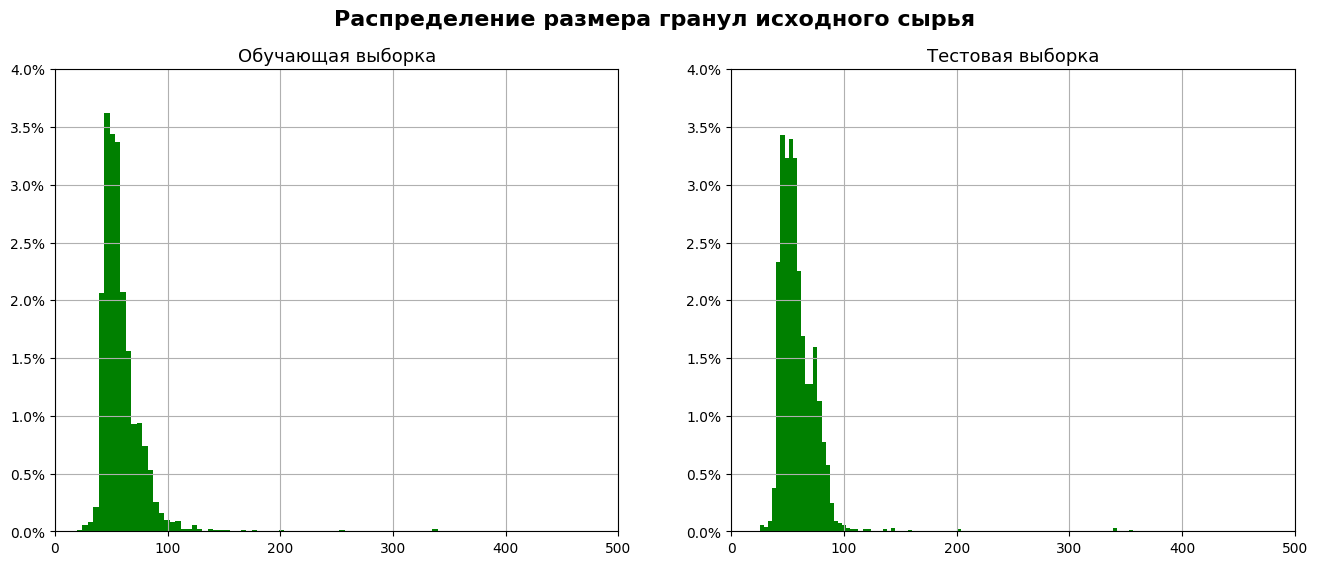

In [19]:
with plt.style.context(style='seaborn-dark-palette'):   

    fig, axes = plt.subplots(1, 2, sharex=True, figsize=(16, 6))
    fig.suptitle('Распределение размера гранул исходного сырья', fontsize=16, fontweight='bold')
        
    axes[0].set_title('Обучающая выборка', fontsize=13)
    axes[0].hist(df_train['rougher.input.feed_size'], bins=100, color='green', density=True)
    axes[0]
    axes[0].grid(True)
    axes[0].set_yticks([i for i in np.arange(0, 0.045, 0.005)], 
                       ['{:.1%}'.format(i) for i in np.arange(0, 0.045, 0.005)])
    axes[0].set_ylim(0, 0.04)
    axes[0].set_xlim(0, 500)

    axes[1].set_title('Тестовая выборка', fontsize=13)
    axes[1].hist(df_test['rougher.input.feed_size'], bins=100, color='green', density=True)
    axes[1].grid(True) 
    axes[1].set_yticks([i for i in np.arange(0, 0.045, 0.005)], 
                       ['{:.1%}'.format(i) for i in np.arange(0, 0.045, 0.005)])
    axes[1].set_ylim(0, 0.04)
    axes[1].set_xlim(0, 500)

    plt.show()

Распределения совпадают, ошибки при прогнозировании быть не должно.

### 3. Построение модели

#### 3.1. Расчет sMAPE

Опишем функцию метрики качества sMAPE описанную в условии. Опишем так, чтобы её можно было применить в кросс-валидации.

In [20]:
def sMAPE(estimator, X, y):
    y_pred = estimator.predict(X)
    value = sum(abs((y - y_pred)) / ((abs(y) + abs(y_pred)) / 2)) / y.shape[0]
    return value

Перед построением модели проверим корреляцию признаков, которые есть в обоих таблицах, чтобы избежать ошибок при обучении модели линейной регрессии.

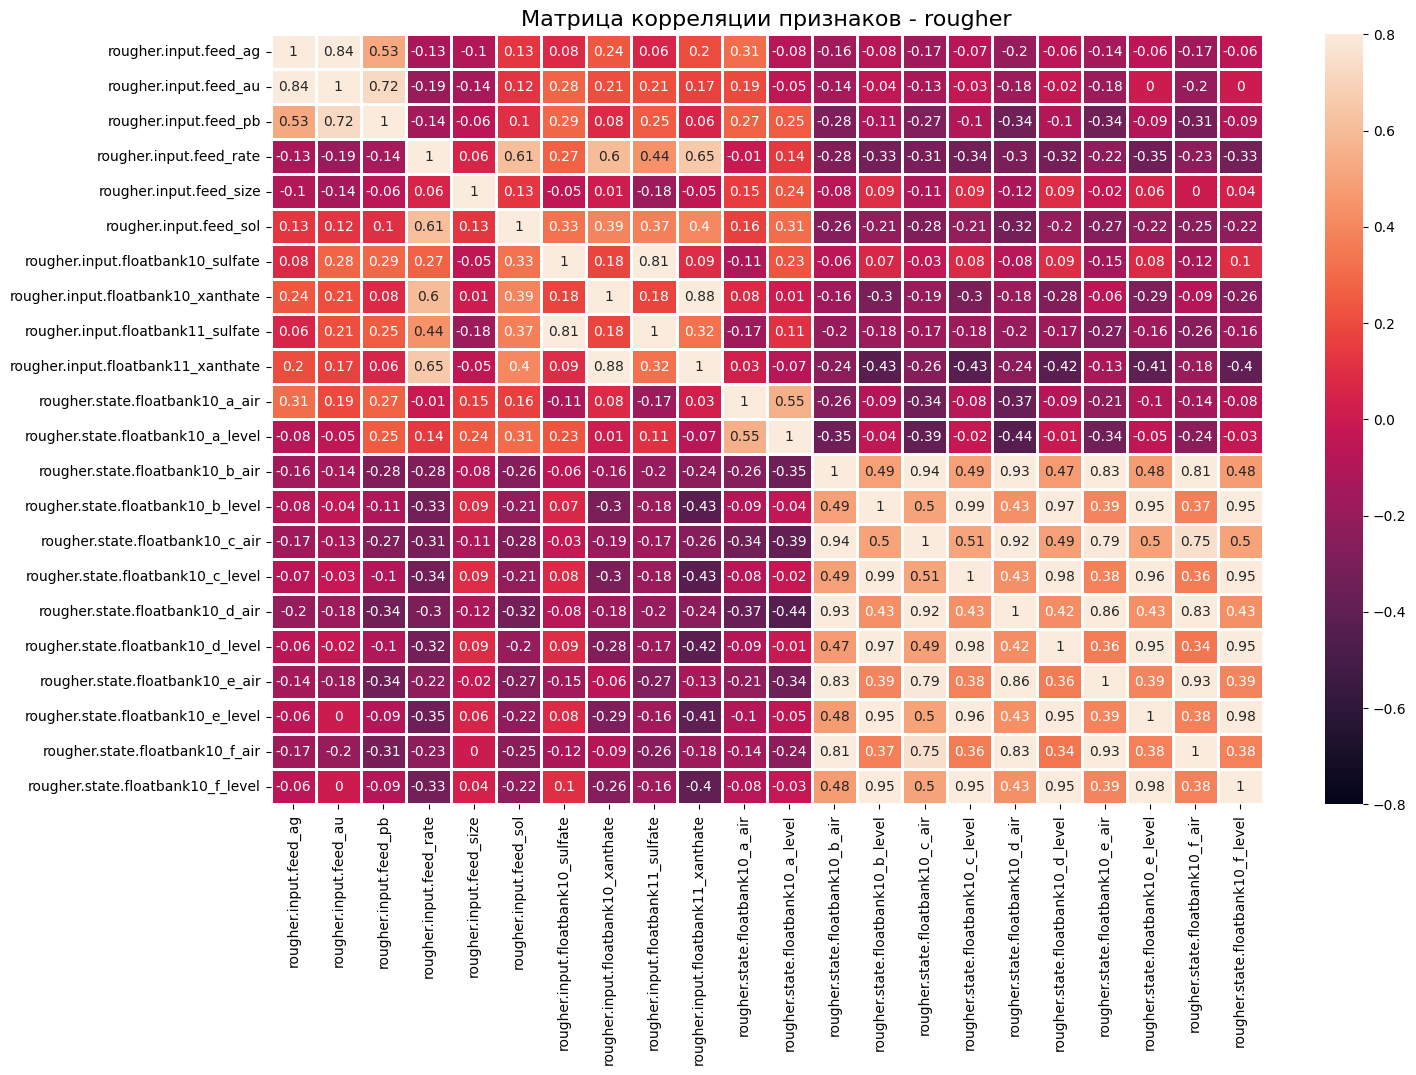

In [21]:
plt.figure(figsize=(16, 10))
sns.heatmap(df_train[['rougher.input.feed_ag', 'rougher.input.feed_au',
                      'rougher.input.feed_pb', 'rougher.input.feed_rate',
                      'rougher.input.feed_size', 'rougher.input.feed_sol', 
                      'rougher.input.floatbank10_sulfate', 'rougher.input.floatbank10_xanthate',
                      'rougher.input.floatbank11_sulfate', 'rougher.input.floatbank11_xanthate',
                      'rougher.state.floatbank10_a_air', 'rougher.state.floatbank10_a_level',
                      'rougher.state.floatbank10_b_air', 'rougher.state.floatbank10_b_level',
                      'rougher.state.floatbank10_c_air', 'rougher.state.floatbank10_c_level',
                      'rougher.state.floatbank10_d_air', 'rougher.state.floatbank10_d_level',
                      'rougher.state.floatbank10_e_air', 'rougher.state.floatbank10_e_level',
                      'rougher.state.floatbank10_f_air', 'rougher.state.floatbank10_f_level']].corr().round(2), 
            annot=True, vmax=0.8, vmin=-0.8, linecolor='white', linewidths=1)
plt.title('Матрица корреляции признаков - rougher', fontsize=16)
plt.show()

Убираем признаки: 

- `rougher.input.feed_ag`
- `rougher.input.floatbank11_sulfate` 
- `rougher.input.floatbank11_xanthate` 
- `rougher.state.floatbank10_c_air` 
- `rougher.state.floatbank10_c_level` 
- `rougher.state.floatbank10_d_air` 
- `rougher.state.floatbank10_d_level` 
- `rougher.state.floatbank10_e_air` 
- `rougher.state.floatbank10_e_level` 
- `rougher.state.floatbank10_f_air` 
- `rougher.state.floatbank10_f_level`

Оставшиеся запишем в переменную для удобства

In [22]:
columns = ['rougher.input.feed_au', 
           'rougher.input.feed_pb', 
           'rougher.input.feed_rate', 
           'rougher.input.feed_size', 
           'rougher.input.feed_sol', 
           'rougher.input.floatbank10_sulfate', 
           'rougher.input.floatbank10_xanthate',
           'rougher.state.floatbank10_a_air', 
           'rougher.state.floatbank10_a_level',
           'rougher.state.floatbank10_b_air', 
           'rougher.state.floatbank10_b_level']

Подготовим признаки и обучим модель для расчета значения `rougher.output.recovery`.

In [23]:
feature = df_train[columns]
target = df_train['rougher.output.recovery']

Напишем функцию поиска оптимальной модели.  

In [24]:
def search_model(feature, target):

    model_lr = LinearRegression()
    scores = cross_val_score(estimator=model_lr, X=feature, y=target, cv=5, scoring=sMAPE)
    lr_score = sum(scores) / len(scores)

    max_score_dt = 1000
    max_score_rf = 1000
    best_depth_dt = None
    best_depth_rf = None 
    best_estimators = None

    for depth in range(1, 11):
        model_dt = DecisionTreeRegressor(max_depth=depth, random_state=123)
        scores_dt = cross_val_score(estimator=model_dt, X=feature, y=target, cv=5, scoring=sMAPE)
        dt_score = sum(scores_dt) / len(scores_dt)

        if dt_score < max_score_dt:
            max_score_dt = dt_score
            best_depth_dt = depth

        for est in range(10, 101, 10):
            model_rf = RandomForestRegressor(max_depth=depth, n_estimators=est, random_state=123, n_jobs=-1)
            scores_rf = cross_val_score(estimator=model_rf, X=feature, y=target, cv=5, scoring=sMAPE)
            rf_score = sum(scores_rf) / len(scores_rf)

            if rf_score < max_score_rf:
                max_score_rf = rf_score
                best_depth_rf = depth 
                best_estimators = est

    print('Средний sMAPE линейной регрессии = {:.2%}'.format(lr_score))
    print('Средний sMAPE решающего дерева = {:.2%}, лучшая глубина = {}'.format(max_score_dt, best_depth_dt))
    print('Средний sMAPE случайного леса = {:.2%}, лучшая глубина = {}, количество деревьев = {}'.format(
          max_score_rf, best_depth_rf, best_estimators))

Поиск

In [25]:
search_model(feature, target) 

Выбираем модель **`RandomForestRegressor()`**.  

Целевой признак для тестовой выборки надо извлечь из полного датафрейма. Проверим уникальность дат в таблице

In [26]:
print(df_full.shape[0])
print(df_full['date'].nunique())

Рассчитаем SMAPE.

In [27]:
feature_test = df_test[columns]
target_test = df_full[df_full['date'].isin(df_test['date'])]['rougher.output.recovery']

model_rough = RandomForestRegressor(max_depth=5, n_estimators=80, random_state=123, n_jobs=-1)
model_rough.fit(feature, target)

print('sMAPE на тестовой выборке = {:.2%}'.format(sMAPE(estimator=model_rough, X=feature_test, y=target_test)))

Теперь сравним результат с данными константной модели.

In [28]:
model_dummy = DummyRegressor()
model_dummy.fit(feature, target)

print('sMAPE на константной модели = {:.2%}'.format(sMAPE(estimator=model_dummy, X=feature_test, y=target_test)))

Наша модель работает лучше, хоть и не намного.

Отлично. Теперь для прогнозирования значения `final.output.recovery`, нам нужно больше признаков. Проверим их корреляцию. Признаки `rougher` мы уже изучали, перейдём к `primary`.

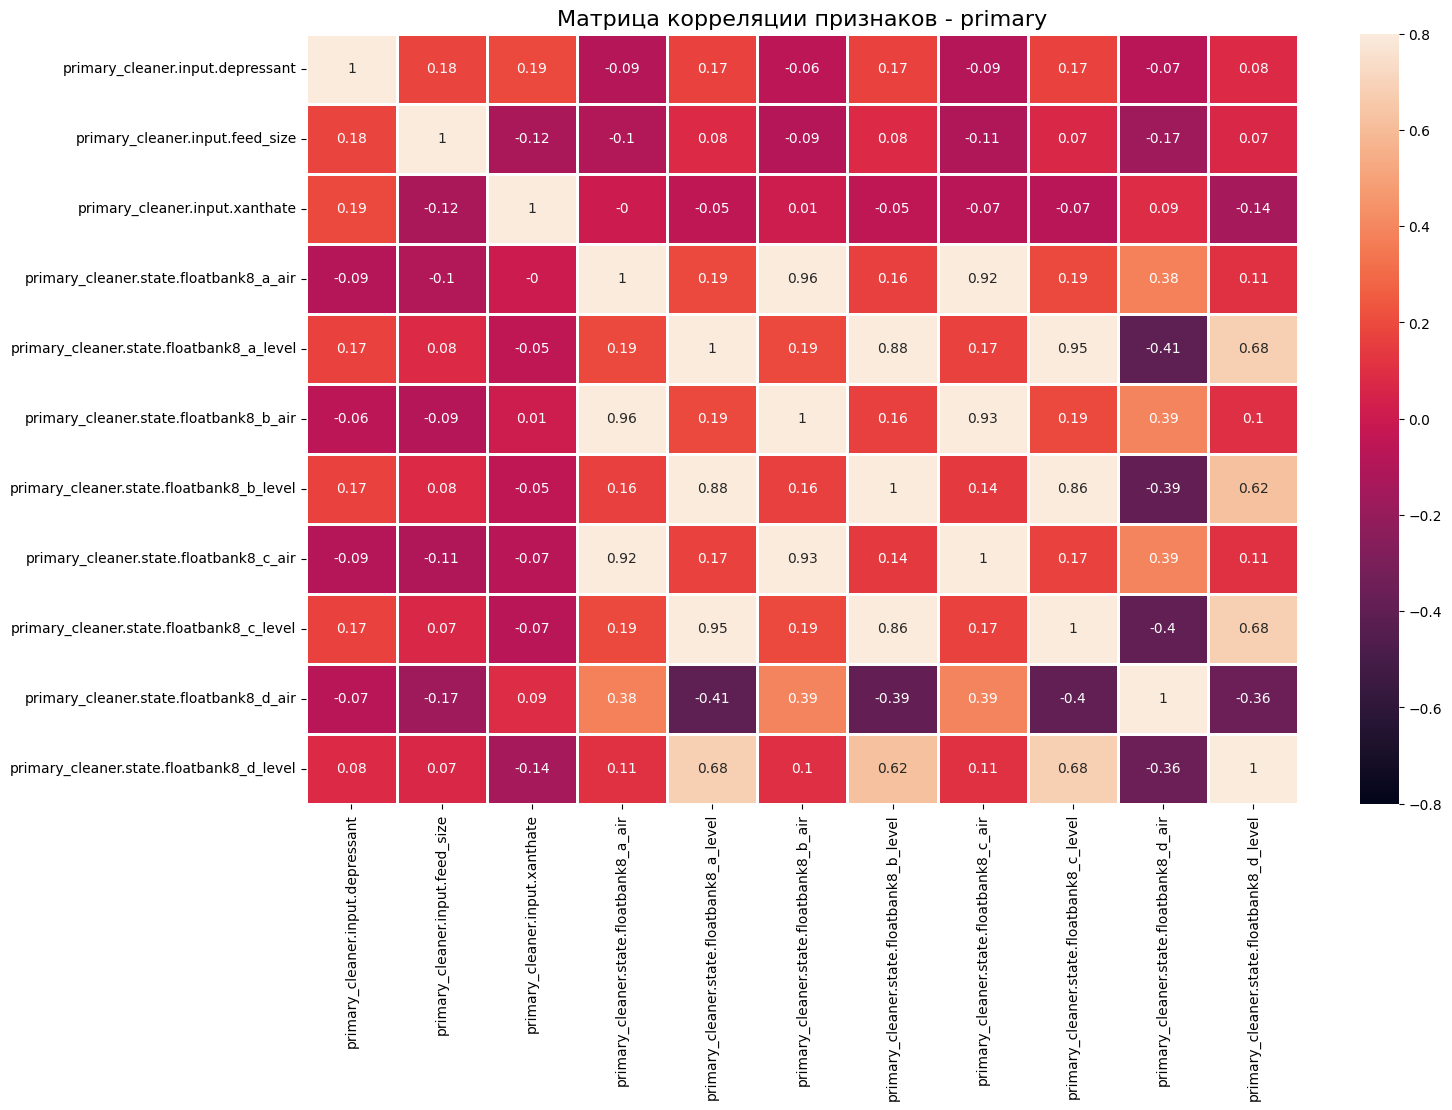

In [29]:
plt.figure(figsize=(16, 10))
sns.heatmap(df_train[['primary_cleaner.input.depressant', 'primary_cleaner.input.feed_size',
       'primary_cleaner.input.xanthate',
       'primary_cleaner.state.floatbank8_a_air',
       'primary_cleaner.state.floatbank8_a_level',
       'primary_cleaner.state.floatbank8_b_air',
       'primary_cleaner.state.floatbank8_b_level',
       'primary_cleaner.state.floatbank8_c_air',
       'primary_cleaner.state.floatbank8_c_level',
       'primary_cleaner.state.floatbank8_d_air',
       'primary_cleaner.state.floatbank8_d_level']].corr().round(2),
            annot=True, vmax=0.8, vmin=-0.8, linecolor='white', linewidths=1)
plt.title('Матрица корреляции признаков - primary', fontsize=16)
plt.show()

Убираем признаки:

- `primary_cleaner.state.floatbank8_b_air`
- `primary_cleaner.state.floatbank8_b_level`
- `primary_cleaner.state.floatbank8_c_air`
- `primary_cleaner.state.floatbank8_c_level`  

Теперь изучим `secondary`.

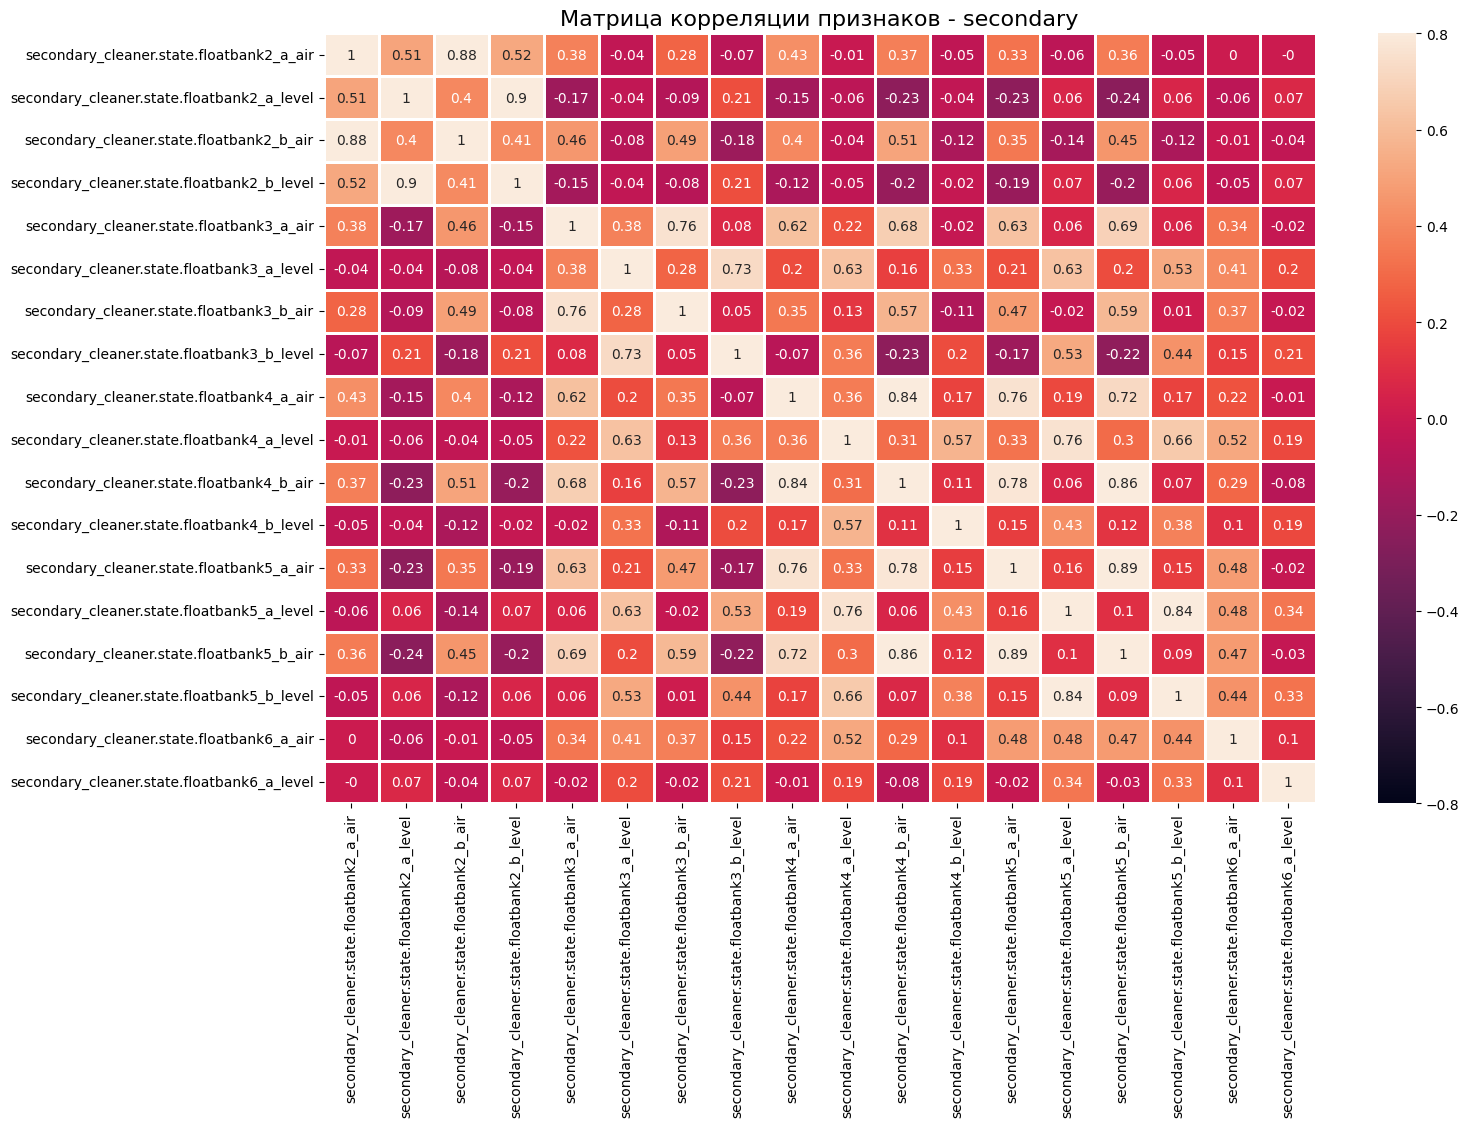

In [30]:
plt.figure(figsize=(16, 10))
sns.heatmap(df_train[['secondary_cleaner.state.floatbank2_a_air',
       'secondary_cleaner.state.floatbank2_a_level',
       'secondary_cleaner.state.floatbank2_b_air',
       'secondary_cleaner.state.floatbank2_b_level',
       'secondary_cleaner.state.floatbank3_a_air',
       'secondary_cleaner.state.floatbank3_a_level',
       'secondary_cleaner.state.floatbank3_b_air',
       'secondary_cleaner.state.floatbank3_b_level',
       'secondary_cleaner.state.floatbank4_a_air',
       'secondary_cleaner.state.floatbank4_a_level',
       'secondary_cleaner.state.floatbank4_b_air',
       'secondary_cleaner.state.floatbank4_b_level',
       'secondary_cleaner.state.floatbank5_a_air',
       'secondary_cleaner.state.floatbank5_a_level',
       'secondary_cleaner.state.floatbank5_b_air',
       'secondary_cleaner.state.floatbank5_b_level',
       'secondary_cleaner.state.floatbank6_a_air',
       'secondary_cleaner.state.floatbank6_a_level']].corr().round(2),
            annot=True, vmax=0.8, vmin=-0.8, linecolor='white', linewidths=1)
plt.title('Матрица корреляции признаков - secondary', fontsize=16)
plt.show()

Убираем:

- `secondary_cleaner.state.floatbank2_b_air`
- `secondary_cleaner.state.floatbank2_b_level`
- `secondary_cleaner.state.floatbank3_b_air`
- `secondary_cleaner.state.floatbank3_b_level`
- `secondary_cleaner.state.floatbank4_b_air`
- `secondary_cleaner.state.floatbank4_b_level`
- `secondary_cleaner.state.floatbank5_b_air`
- `secondary_cleaner.state.floatbank5_b_level`

То что осталось запишем в новый список.

In [31]:
cols = [
        'rougher.input.feed_au', 
        'rougher.input.feed_pb', 
        'rougher.input.feed_rate', 
        'rougher.input.feed_size', 
        'rougher.input.feed_sol', 
        'rougher.input.floatbank10_sulfate', 
        'rougher.input.floatbank10_xanthate',
        'rougher.state.floatbank10_a_air', 
        'rougher.state.floatbank10_a_level',
        'rougher.state.floatbank10_b_air', 
        'rougher.state.floatbank10_b_level', 
        'primary_cleaner.input.depressant', 
        'primary_cleaner.input.feed_size',
        'primary_cleaner.input.xanthate',
        'primary_cleaner.state.floatbank8_a_air',
        'primary_cleaner.state.floatbank8_a_level',
        'primary_cleaner.state.floatbank8_d_air',
        'primary_cleaner.state.floatbank8_d_level', 
        'secondary_cleaner.state.floatbank2_a_air',
        'secondary_cleaner.state.floatbank2_a_level',
        'secondary_cleaner.state.floatbank3_a_air',
        'secondary_cleaner.state.floatbank3_a_level',
        'secondary_cleaner.state.floatbank4_a_air',
        'secondary_cleaner.state.floatbank4_a_level',
        'secondary_cleaner.state.floatbank5_a_air',
        'secondary_cleaner.state.floatbank5_a_level',
        'secondary_cleaner.state.floatbank6_a_air',
        'secondary_cleaner.state.floatbank6_a_level']

Подготовим признаки для расчета `final.output.recovery`.

In [32]:
feature = df_train[cols]
target = df_train['final.output.recovery']

Ищем.

In [33]:
search_model(feature, target)

Лучший результат показала модель случайного леса.  
Её и возьмем для тестовых данных.

In [34]:
feature_test = df_test[cols]
target_test = df_full[df_full['date'].isin(df_test['date'])]['final.output.recovery']

model_final = RandomForestRegressor(max_depth=8, n_estimators=90, random_state=123, n_jobs=-1)
model_final.fit(feature, target)

print('sMAPE на тестовой выборке = {:.2%}'.format(sMAPE(estimator=model_final, X=feature_test, y=target_test)))

Проверим на константной модели.

In [35]:
model_dummy = DummyRegressor()
model_dummy.fit(feature, target)

print('sMAPE на константной модели = {:.2%}'.format(sMAPE(estimator=model_dummy, X=feature_test, y=target_test)))

Мы опять впереди.

Найдем итоговое значение по формуле из условия.

In [36]:
final_value = 0.25 * 0.041 + 0.75 * 0.0788
print('Итоговое sMAPE = {:.2%}'.format(final_value))

Так же найдем итоговое sMAPE для константной модели.

In [37]:
constant_final_value = 0.25 * 0.0611 + 0.75 * 0.0941
print('Итоговое sMAPE константной модели = {:.2%}'.format(constant_final_value))

Наша модель прогнозирует лучше.

### 4. Выводы

В ходе предобработки и разведочного анализа было установлено следующее:  

- В тестовом наборе данных отсутсвует ряд признаков - это некоторые данные о результатах очистки сырья и концентрата, а так же данные об итоговых результатах процесса.  
- Данные **`rougher.output.recovery`** посчитаны корректно.  
- В процессе флотации и очистки сырья лучший результат показывает золото - его концентрация существенно возрастает на каждом этапе, затем свинец. По серебру результат не однозначный.  
- Распределение размеров гранул исходного сырья в тренировочной и тестовой выборке совпадают, так что модель не должна ошибиться при прогнозировании.  
- Результаты кросс-валидации модели по формуле **sMAPE** показали лучший результат для модели случайного леса при прогнозе **`rougher.output.recovery`**, и **`final.output.recovery`**.  
- На тестовой выборке метрика качества (симметричное среднее абсолютное процентное отклонение) показала результаты 4.1% для **`rougher.output.recovery`** и 7.12% для **`final.output.recovery`**. Константная модель показала более низкие результаты = 6.11% и 9.26% соответственно.
- Итоговое **sMAPE** нашей модели = 6.93%. Случайной = 8.58%.